# Solução:  California Housing Prices

## Objetivos:

O objetivo desse desafio é analisar os dados do case e estruturar uma Feature Engineering básica apenas com os dados existentes, sem transformar ou combinar features ou mesmo adicionar informações externas. 

Ao final do desafio, será treinado um modelo de regressão linear com as features obtidas. Esse modelo será testado contra uma massa de teste, separada previamente.


## Sobre o Case

### Case baseado no dataset do Kaggle: "California Housing Prices"

Esse desafio é baseado em um dataset aberto do Kaggle ([https://www.kaggle.com](https://www.kaggle.com)) de 2018, de onde é possível estimar o preço de um imóvel pertencente a uma dada região na Califórnia. 

O dataset original foi extraído do repositório StatLib, que não está mais disponível. Os dados que o compôem foram retirados do Censo realizado na Califórnia em 1990 e modificado para servir como base de treinamento.


Link para o dataset no Kaggle: [https://www.kaggle.com/harrywang/housing/data](https://www.kaggle.com/harrywang/housing/data)


### Descrição dos Dados Originais:

#### Tamanho do Dataset:

* `20.640` data points

#### Variável dependente:

* `median_house_value`:  (float) variável dependente com o valor da mediana do preço de imóvel na região

#### Features: 

* `longitude`/`latitude`: (floats) posição global da região
* `housing_median_age`: (float) mediana da idade (em anos) das casas da região
* `total_rooms`: (float) total de aposentos da região
* `total_bedrooms`: (float) total de quartos da região
* `population`: (float) população total da região
* `households`: (float) quantidade total de imóveis da região
* `median_income`: (float) mediana do salário (por hora) de uma pessoa na região
* `ocean_proximity`: (string) categorias relativas à distância do oceano

É interessante ressaltar que `207` valores foram retirados aleatoriamnete da feature `total_bedrooms` por motivos acadêmicos.


### Modificação dos dados para o Desafio:

Para tornar o desafio mais fácil de avaliar, a massa de dados original foi dividida em duas massas, uma para treino e outra para teste, ambas contendo `10.320` elementos.

Também foram removidos aleatoriamente ainda mais valores da massa de dados e em mais features. Isso torna o processo de Feature Engineering mais instrutivo, pois aproxima-se da realidade do trabalho de um Data Scientist.

___

# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import os
import pandas as pd

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, PolynomialFeatures, StandardScaler

# Dataset:

## Carregando os dados

In [4]:
dataset = pd.read_csv("data/california_housing_train.csv", index_col=0)
x_train = dataset.drop(["median_house_value"], axis=1)
y_train = dataset[["median_house_value"]]

In [5]:
print(f"shape: {x_train.shape}")
x_train.head()

shape: (10320, 9)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
region_id,,,,,,,,,
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,NEAR BAY
10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,NEAR BAY


In [6]:
print(f"shape: {y_train.shape}")
y_train.head()

shape: (10320, 1)


,median_house_value
region_id,
1,358500.0
2,352100.0
4,342200.0
9,261100.0
10,281500.0


In [7]:
dataset = pd.read_csv("data/california_housing_test.csv", index_col=0)
x_test = dataset.drop(["median_house_value"], axis=1)
y_test = dataset[["median_house_value"]]

In [8]:
print(f"shape: {x_test.shape}")
x_test.head()

shape: (10320, 9)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
region_id,,,,,,,,,
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,NaN,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,NEAR BAY


In [9]:
print(f"shape: {y_test.shape}")
y_test.head()

shape: (10320, 1)


,median_house_value
region_id,
0,452600.0
3,341300.0
5,269700.0
6,299200.0
7,241400.0


# Problemas

## A) Features Numéricas

Features numéricas são as primeiras a serem tratadas, por serem as mais fáceis de compreender e de relacionar com o problema. As seções a seguir focam no tratamento e limpeza dessas features, o primeiro passo na engenharia de features.


### Distribuição das Features

In [10]:
""" Complete os espaços com ? """
numerical_cols = ["longitude", "latitude", 
                  "housing_median_age", "total_rooms", "total_bedrooms", 
                  "population", "households", "median_income"]

In [11]:
# descrevendo as distribuições
cuts = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
x_train[numerical_cols].describe(percentiles=cuts)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,10320.000000,10320.000000,10008.000000,10320.000000,10320.000000,9895.000000,10320.000000,10068.000000
mean,-119.589222,35.656511,28.549261,2640.735078,539.720252,1430.154725,501.228295,3.866899
std,2.011871,2.137569,12.579865,2144.675733,416.489332,1136.674762,380.010055,1.908804
min,-124.300000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
1%,-123.230000,32.681900,4.000000,155.330000,36.000000,85.000000,31.190000,1.057939
5%,-122.470000,32.840000,8.000000,629.000000,138.000000,342.100000,124.000000,1.585140
10%,-122.290000,33.640000,13.000000,946.000000,198.000000,509.000000,183.000000,1.896430
25%,-121.810000,33.940000,18.000000,1453.000000,295.000000,792.000000,280.000000,2.559100
50%,-118.520000,34.270000,29.000000,2144.000000,438.500000,1171.000000,413.000000,3.519200
75%,-118.020000,37.720000,37.000000,3153.250000,650.000000,1738.000000,607.000000,4.770800


Para tomada de decisão, é sempre mais informativo usar visualizações. Com elas é possível observar o formato da distribuição (normal, exponencial, logarítmica, etc) e os outliers.

Verificando as distribuições com histogramas:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015E99A78E48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000015E9A1FCF60>]], dtype=object)

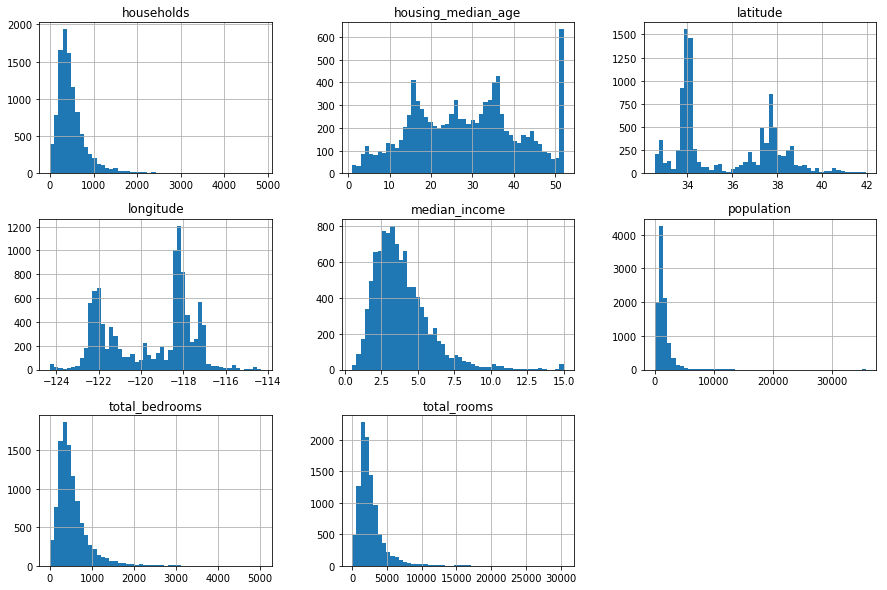

In [12]:
x_train[numerical_cols].hist(bins=50, figsize=(15,10))

###  Detecção e Tratamento de Nulos

Conhecendo a distribuição das features, já é possível traçar estratégias de tratamento de valores nulos. A primeira tarefa é detectar a proporção de nulos nos dados.


* Verificar quantidade de Nulos em cada feature
* Entender que Nulos podem aparecer também nos dados de teste, portanto apenas descartar o dado não resolve
* Entender que medida (média ou mediana) deve ser imputada em cada feature

In [13]:
x_null = x_train[numerical_cols].isnull()
null_data = pd.DataFrame({
    "count": x_null.sum(),
    "mean": x_null.mean()
})
null_data

,count,mean
longitude,0,0.000000
latitude,0,0.000000
housing_median_age,312,0.030233
total_rooms,0,0.000000
total_bedrooms,0,0.000000
population,425,0.041182
households,0,0.000000
median_income,252,0.024419


Normalmente a ocorrência de valores nulos ocorre por algum ruído no processo de obtenção de dados, o que significa que muito provavelmente eles ocorrerão também em dados de produção.

Existem algumas técnicas de tratamento de valores nulos:

- Atribuir um valor pafrão fora da distribuição;
- Criar modelos para inferir os valores a partir das outras features;
- Imputar um valor referente à distribuição:
    - média
    - mediana
    
Para features numéricas em que conhecemos a distribuição mas não foram tratados os outliers, o mais recomendado é utilizar a **mediana**, cujo valor é pouco afetado por outliers.

In [14]:
class NumericalFeaturesImputer(BaseEstimator, TransformerMixin):
    """ Classe de Feature Transformer baseada em um Imputer de Mediana.
        Esse imputer mantém a entrada X como um DataFrame em vez de transformar em numpy.array.
    """
    
    def __init__(self, columns):
        self.imputer = Imputer(strategy="median")
        self.columns = columns
        
    def fit(self, X, y=None, **fit_params):
        self.imputer.fit(X.loc[:, self.columns])
        return self
    
    def transform(self, X):
        X_t = X.copy()
        X_t.loc[:, self.columns] = self.imputer.transform(X_t.loc[:, self.columns])
        return X_t
    

In [15]:
# sanity check 1: tranformation keeps columns 
numerical_imputer = NumericalFeaturesImputer(numerical_cols)
x_train = numerical_imputer.fit_transform(x_train)
x_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
region_id,,,,,,,,,
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,NEAR BAY
10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,NEAR BAY


In [16]:
# sanity check 2: NUll data replaced
x_null = x_train[numerical_cols].isnull()
null_data = pd.DataFrame({
    "count": x_null.sum(),
    "mean": x_null.mean()
})
null_data

,count,mean
longitude,0,0.0
latitude,0,0.0
housing_median_age,0,0.0
total_rooms,0,0.0
total_bedrooms,0,0.0
population,0,0.0
households,0,0.0
median_income,0,0.0


### Transformação Logarítmica de Features

Com os histogramas, já fica evidente que a distribuição de algumas features é exponencial. A análise de outliers desse tipo de distribuição pode ser prejudicada pela alta concentração de elementos em uma pequena parte do domínio. 

Uma forma de corrigir essa distorção é transformar esses dados com a função **logarítmica**; a transformação com essa função torna a distribuição das features mais próxima da normal.

In [17]:
""" Complete os espaços com ? """
log_cols = ["total_rooms", "total_bedrooms", "population", "households", "median_income"]

In [18]:
class LogFeaturesTransform(BaseEstimator, TransformerMixin):
    """ Classe de Feature Transformer para aplicar log em valores numéricos.
        Esse imputer mantém a entrada X como um DataFrame em vez de transformar em numpy.array.
    """
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        X_t = X[self.columns].apply(np.log).rename(columns=lambda c: f"log_of_{c}")
        return X.join(X_t)
    

Ainda é cedo para descartar as features originais tratadas, pois elas podem ter ainda algum poder preditivo que pode ficar ocluso pela transformação. O descarte de features normalmente é feito quando se detecta multi-colinearidade entre as features ou durante uma etapa de _feature selection_.

Por hora, as novas features serão integradas ao dataset original.

In [19]:
x_train = LogFeaturesTransform(log_cols).fit_transform(x_train)

In [20]:
log_cols = [f"log_of_{c}" for c in log_cols]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015E9A40EB00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000015E9AACC198>]], dtype=object)

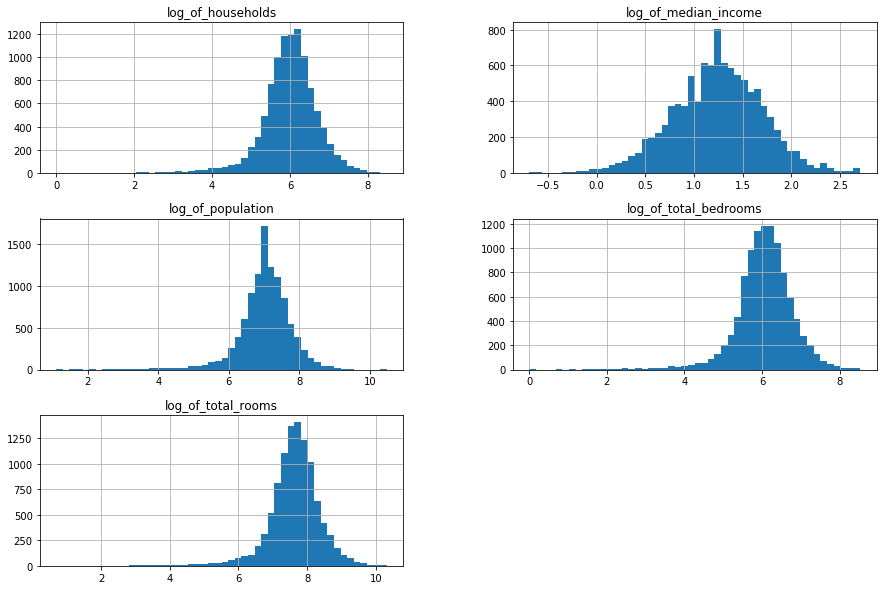

In [21]:
x_train[log_cols].hist(bins=50, figsize=(15,10))

###  Detecção e Remoção de Outliers

Outliers podem deformar a percepção do domínio para o aprendizado de um modelo linear, impedindo o mesmo de encontrar uma solução correta. 

#### Verificando os Box Plots para observar os Outliers

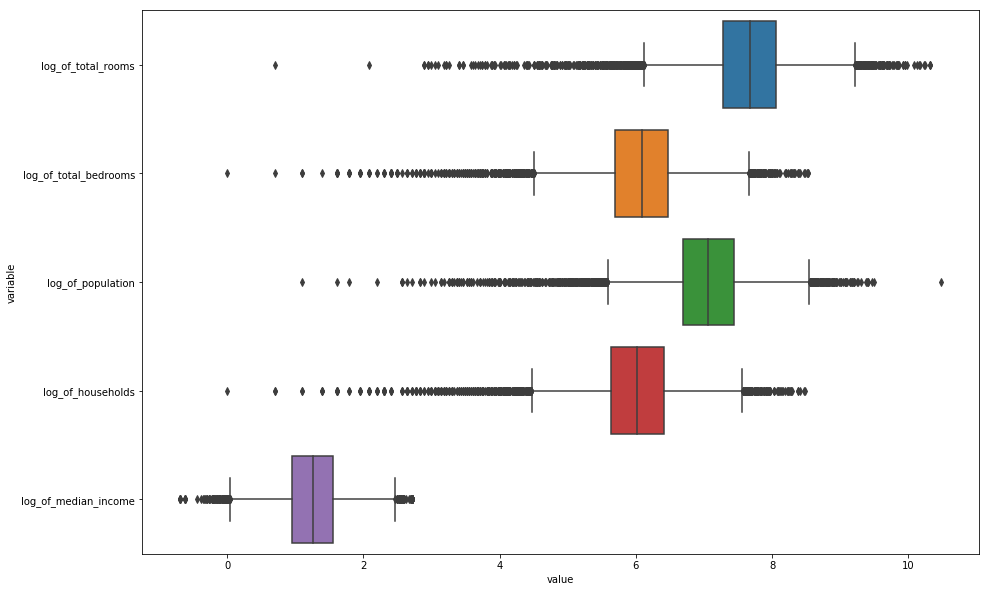

In [22]:
""" Escreva a solução aqui """
plt.figure(figsize=(15,10))

sns.boxplot(x="value", y="variable", data=x_train[log_cols].melt())

#### Aplicando os cortes:

In [23]:
# inicialização
keep_index = pd.Series(index=x_train.index, data=True)
cuts_table = pd.DataFrame(columns=["count", "percent"])

In [24]:
# Template para os cortes: replique essa célula para cada corte definido no item anterior

""" Complete os espaços com ? """

feat = "log_of_total_rooms"
lim_inf = 5
lim_sup = 10

cuts_index = (x_train[feat] < lim_inf) | ((x_train[feat] > lim_sup)) 
cuts_table = cuts_table.append(
    pd.DataFrame(
        index=[f"{lim_inf} <= {feat} <= {lim_sup}"],
        columns=["count", "percent"],
        data=[[cuts_index.sum(), cuts_index.mean()]]
    )
)
keep_index &= ~cuts_index

In [25]:
# Template para os cortes: replique essa célula para cada corte definido no item anterior

""" Complete os espaços com ? """

feat = "log_of_total_bedrooms"
lim_inf = 4
lim_sup = 8

cuts_index = (x_train[feat] < lim_inf) | ((x_train[feat] > lim_sup)) 
cuts_table = cuts_table.append(
    pd.DataFrame(
        index=[f"{lim_inf} <= {feat} <= {lim_sup}"],
        columns=["count", "percent"],
        data=[[cuts_index.sum(), cuts_index.mean()]]
    )
)
keep_index &= ~cuts_index

In [26]:
# Template para os cortes: replique essa célula para cada corte definido no item anterior

""" Complete os espaços com ? """

feat = "log_of_population"
lim_inf = 5
lim_sup = 9

cuts_index = (x_train[feat] < lim_inf) | ((x_train[feat] > lim_sup)) 
cuts_table = cuts_table.append(
    pd.DataFrame(
        index=[f"{lim_inf} <= {feat} <= {lim_sup}"],
        columns=["count", "percent"],
        data=[[cuts_index.sum(), cuts_index.mean()]]
    )
)
keep_index &= ~cuts_index

In [27]:
# Template para os cortes: replique essa célula para cada corte definido no item anterior

""" Complete os espaços com ? """

feat = "log_of_households"
lim_inf = 4
lim_sup = 8

cuts_index = (x_train[feat] < lim_inf) | ((x_train[feat] > lim_sup)) 
cuts_table = cuts_table.append(
    pd.DataFrame(
        index=[f"{lim_inf} <= {feat} <= {lim_sup}"],
        columns=["count", "percent"],
        data=[[cuts_index.sum(), cuts_index.mean()]]
    )
)
keep_index &= ~cuts_index

In [28]:
# Template para os cortes: replique essa célula para cada corte definido no item anterior

""" Complete os espaços com ? """

feat = "log_of_median_income"
lim_inf = -.5
lim_sup = 2.7

cuts_index = (x_train[feat] < lim_inf) | ((x_train[feat] > lim_sup)) 
cuts_table = cuts_table.append(
    pd.DataFrame(
        index=[f"{lim_inf} <= {feat} <= {lim_sup}"],
        columns=["count", "percent"],
        data=[[cuts_index.sum(), cuts_index.mean()]]
    )
)
keep_index &= ~cuts_index

In [29]:
# visualizando os cortes
cuts_table.append(
    pd.DataFrame(
        index=[f"Total Elements Cut"],
        columns=["count", "percent"],
        data=[[(~keep_index).sum(), (~keep_index).mean()]]
    )
)

,count,percent
5 <= log_of_total_rooms <= 10,109,0.010562
4 <= log_of_total_bedrooms <= 8,199,0.019283
5 <= log_of_population <= 9,197,0.019089
4 <= log_of_households <= 8,216,0.020930
-0.5 <= log_of_median_income <= 2.7,41,0.003973
Total Elements Cut,282,0.027326


In [30]:
# aplicação do corte total
ori_size = x_train.shape[0]

x_train = x_train.loc[keep_index]

new_size = x_train.shape[0]

print(f"Size of 'x_train' before Cuts:\t {ori_size}")
print(f"Size of 'x_train' after Cuts:\t {new_size} (-{100. * (~keep_index).mean(): 0.2f} %)")

Size of 'x_train' before Cuts:	 10320
Size of 'x_train' after Cuts:	 10038 (- 2.73 %)


## B) Feature Categórica

Features Categóricas são um pouco mais interessantes de tratar do que as numéricas, já que existem muitas maneiras de se transformar textos ou símbolos em valores numéricos. 

Vale lembrar que todo modelo de machine learning compreende o mundo através de valores numéricos, por serem modelos matemáticos de busca de solução ótima. Alguns frameworks atuais permitam que se coloquem valores simbólicos ou de texto marcados com a tag 'category' diretamente no dataset, mas por trás o proprio framework transforma esses dados em números.

### Análise da Distribuição das Categorias

#### Verificação da quantidade de dados em cada categoria

É interessante verificar a quantidade de dados em cada categoria, pois categoriass mal representadas podem criar conceitos enviesados do modelo sobre o domínio. Por exemplo, em um dataset em que uma categoria só ocorra uma única vez e a variável dependente exatamente nesse elemento seja muito alta, um modelo treinado pode assumir que a presença dessa categoria já indique uma saída alta.

In [31]:
# verificando a distribuiçlão das categorias na massa de treino
x_train["ocean_proximity"].fillna(" - NaN - ").value_counts()

<1H OCEAN     4477
INLAND        3128
NEAR OCEAN    1225
NEAR BAY      1114
 - NaN -        91
ISLAND           3
Name: ocean_proximity, dtype: int64

Nem sempre é possível verificar a distribuição exata dos dados de produção, mas a massa de teste normalmente dá uma boa aproximação dela. 

In [32]:
# verificando a distribuiçlão das categorias na massa de teste
x_test["ocean_proximity"].fillna(" - NaN - ").value_counts()

<1H OCEAN     4513
INLAND        3230
NEAR OCEAN    1373
NEAR BAY      1135
 - NaN -        67
ISLAND           2
Name: ocean_proximity, dtype: int64

#### Definir o tratamento de categorias pouco representativos:

Pode-se observar que a categoria `ISLAND` tem uma representatividade mínima em todo o dataset, tornando essa categoria a única candidata à eliminação. Como já existem elementos com a categoria nula nesse dataset, a melhor estratégia é juntar a categoria `ISLAND` aos nulos e tratá-los (próxima seção).

###  Detecção e Tratamento de Nulos

Como já foram identificados elementos em que a categoria é nula, é importante tratar esses elementos apropriadamente.

Existem algumas estratégias para tratamento de nulos:

- Criar uma categoria `NULL` e usar como um símbolo válido do sistema;
- Criar modelos para inferir os valores a partir das outras features;
- Imputar um valor referente à distribuição: a `moda` (valor com a maior frequência)

Como existe a informação de que a variável categórica foi criada a partir da anotação manual do autor do dataset e que o mesmo utilizou as coordenadas `latitude` e `longitude`, a melhor estratégia é criar um `Imputer` que **busque a categoria do elemento usando as coordenadas geográfica**. 

In [33]:
""" Complete os espaços com ? """

from sklearn.linear_model import LogisticRegression

class CategoricalFeaturesImputer(BaseEstimator, TransformerMixin):
    """ Classe de Feature Transformer baseada em um Imputer Categórico que busca a categoria 
        do elemento mais próximo.
        Esse imputer mantém a entrada X como um DataFrame em vez de transformar em numpy.array.
    """
    
    def __init__(self, valid_categories):
        self.valid_categories = valid_categories
        self.imputer = LogisticRegression(
            max_iter=1000,
            solver="newton-cg", 
            multi_class="multinomial"
        )
        
    def fit(self, X, y=None, **fit_params):
        target_feat = "ocean_proximity"
        inputs_cols = ["latitude", "longitude"]
        
        index = X[target_feat].isin(self.valid_categories)
        
        x_train = X.loc[index, inputs_cols]
        y_train = X.loc[index, target_feat]
        
        self.imputer.fit(x_train, y_train)
        return self
    
    def transform(self, X):
        target_feat = "ocean_proximity"
        inputs_cols = ["latitude", "longitude"]
        
        X_t = X.copy()
        X_t.loc[:, target_feat] = self.imputer.predict(X_t.loc[:, inputs_cols])
        return X_t
    

In [34]:
# sanity check

""" Complete os espaços com ? """

valid_categories = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY"]

x_valid = x_test[x_test.ocean_proximity.isnull()]

obj = CategoricalFeaturesImputer(valid_categories).fit(x_train)
obj.transform(x_valid)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
region_id,,,,,,,,,
267,-122.19,37.77,52.0,2329.0,445.0,1144.0,417.0,3.5114,NEAR BAY
856,-122.01,37.58,17.0,4313.0,717.0,2629.0,721.0,5.7579,<1H OCEAN
874,-122.03,37.56,31.0,4981.0,964.0,2841.0,924.0,4.8962,<1H OCEAN
993,-121.72,37.70,17.0,1671.0,352.0,729.0,252.0,6.1023,<1H OCEAN
1038,-120.93,38.50,15.0,1248.0,234.0,529.0,216.0,3.3393,INLAND
1130,-121.65,39.76,31.0,1599.0,318.0,794.0,303.0,3.0000,INLAND
1521,-122.07,37.91,28.0,1731.0,295.0,810.0,295.0,5.0391,NEAR BAY
2034,-119.75,36.73,39.0,2290.0,539.0,1685.0,536.0,1.6325,INLAND
2043,-119.69,36.71,25.0,556.0,79.0,249.0,71.0,4.4583,INLAND


###  Transformação em Dummy Features

A transformação em Dummy Features é a técnica em que os labels são formatados em dados categóricos consumíveis pelo modelo. O formato mais comum é usar uma representação em que cada label é uma nova feature binária onde o valor é **um** onde a feature é igual ao label e **zero** em todo o resto. 

Por exemplo, a transformação do vetor `[a, b, d, b, e, a, c]` seria da forma:

| a | b | c | d | e |
|---|---|---|---|---|
| 1 | 0 | 0 | 0 | 0 |
| 0 | 1 | 0 | 0 | 0 |
| 0 | 0 | 0 | 1 | 0 |
| 0 | 1 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 | 1 |
| 1 | 0 | 0 | 0 | 0 |
| 0 | 0 | 1 | 0 | 0 |

Em modelos lineares existe uma regra de ouro que uma das classes deve permanecer como 'Base' para não haver uma feature linearmente dependente dentro do dataset. Alguns modelos tratam esse problema internamente, mas ainda assim é uma boa prática a ser seguida.

Como é uma etapa de pré-processamento, essa transformação também deve ser feita como uma Feature Transformer.

In [35]:
class CategoricalToDummyFeaturesTransform(BaseEstimator, TransformerMixin):
    """ Classe de Feature Transformer que transforma labels na representação Dummy.
        Esse imputer mantém a entrada X como um DataFrame em vez de transformar em numpy.array.
    """
    
    def __init__(self, categories):
        self.categories = [f"ocean_proximity: {c}" for c in categories]
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):        
        X_t = X.drop("ocean_proximity", axis=1)
        
        dummy = pd.get_dummies(
            X["ocean_proximity"], 
            prefix="ocean_proximity",
            prefix_sep=": "
        ) 
        return X_t.join(dummy.loc[:, self.categories])
    

In [36]:
# sanity check

""" Complete os espaços com ? """

categories = ["INLAND", "NEAR OCEAN", "NEAR BAY"]

CategoricalToDummyFeaturesTransform(categories).transform(x_train).head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,log_of_total_rooms,log_of_total_bedrooms,log_of_population,log_of_households,log_of_median_income,ocean_proximity: INLAND,ocean_proximity: NEAR OCEAN,ocean_proximity: NEAR BAY
region_id,,,,,,,,,,,,,,,,
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,8.867709,7.008505,7.783641,7.037028,2.116424,0,0,1
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,7.290975,5.247024,6.206576,5.176150,1.982022,0,0,1
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,7.394493,5.634790,6.336826,5.556828,1.347086,0,0,1
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,8.174421,6.561031,7.346655,6.570883,1.305952,0,0,1
10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,7.697121,6.073045,6.813445,5.996452,1.164119,0,0,1
11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,8.161375,6.622736,7.315884,6.598509,1.184943,0,0,1
12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,7.820440,6.161207,7.001246,6.148468,1.123305,0,0,1
13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,6.545350,5.252273,5.843544,5.159055,0.983426,0,0,1
16,-122.27,37.85,52.0,1966.0,347.0,1171.0,331.0,2.7750,7.583756,5.849325,7.065613,5.802118,1.020651,0,0,1


## C) Combinação Manual de Features

É uma prática comum agrupar manualmente features por assunto ou grupos de conhecimento, principalmente quando se tem um bom conhecimento do domínio de aplicação. 

Algumas features numéricas nesse dataset são bem relacionadas entre si, sendo imediato pensar em combiná-las. Para manter o padrão no pré-processamento, isso será feito em uma classe de Feature Transformer.

In [37]:
""" Complete os espaços com ? """

class ManuallyCraftedFeaturesTransform(BaseEstimator, TransformerMixin):
    """ Classe de Feature Transformer que aplica transformações manuais.
        Esse imputer mantém a entrada X como um DataFrame em vez de transformar em numpy.array.
    """    
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):        
        X_t = X.copy()
        
        # Início das transformações manuais; 
        # repita as linhas abaixo para cada transformação
        
        X_t.loc[:, "bedrooms per rooms"] = X_t.total_bedrooms / X_t.total_rooms
        X_t.loc[:, "bedrooms per house"] = X_t.total_bedrooms / X_t.households
        X_t.loc[:, "rooms per house"] = X_t.total_rooms / X_t.households
        X_t.loc[:, "people per house"] = X_t.population / X_t.households
        
        # Fim das transformações
        
        return X_t
    

In [38]:
# sanity check

ManuallyCraftedFeaturesTransform().transform(x_train).head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,log_of_total_rooms,log_of_total_bedrooms,log_of_population,log_of_households,log_of_median_income,bedrooms per rooms,bedrooms per house,rooms per house,people per house
region_id,,,,,,,,,,,,,,,,,,
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY,8.867709,7.008505,7.783641,7.037028,2.116424,0.155797,0.971880,6.238137,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY,7.290975,5.247024,6.206576,5.176150,1.982022,0.129516,1.073446,8.288136,2.802260
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,NEAR BAY,7.394493,5.634790,6.336826,5.556828,1.347086,0.172096,1.081081,6.281853,2.181467
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,NEAR BAY,8.174421,6.561031,7.346655,6.570883,1.305952,0.199211,0.990196,4.970588,2.172269
10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,NEAR BAY,7.697121,6.073045,6.813445,5.996452,1.164119,0.197094,1.079602,5.477612,2.263682
11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,NEAR BAY,8.161375,6.622736,7.315884,6.598509,1.184943,0.214673,1.024523,4.772480,2.049046
12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,NEAR BAY,7.820440,6.161207,7.001246,6.148468,1.123305,0.190285,1.012821,5.322650,2.346154
13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,NEAR BAY,6.545350,5.252273,5.843544,5.159055,0.983426,0.274425,1.097701,4.000000,1.982759
16,-122.27,37.85,52.0,1966.0,347.0,1171.0,331.0,2.7750,NEAR BAY,7.583756,5.849325,7.065613,5.802118,1.020651,0.176501,1.048338,5.939577,3.537764


## D) Combinação Polinomial de Features

Uma outra técnica muito utilizada em feature engineering é criar novas features a partir da combinação polinomial de features antigas. Dessa forma, uma solução linear pode ser extendida para uma solução não linear.

In [39]:
class PolynomialFeaturesTransform(BaseEstimator, TransformerMixin):
    """ Classe de Feature Transformer que cria features não lineares usando Transformação Polinomial.
        Esse imputer mantém a entrada X como um DataFrame em vez de transformar em numpy.array.
    """
    
    def __init__(self, features, degree):
        self.features = features
        self.polifeat = PolynomialFeatures(degree=degree, include_bias=False)
        
    def fit(self, X, y=None, **fit_params):
        self.polifeat.fit(X[self.features])
        return self
    
    def transform(self, X):        
        X_t = X.drop(self.features, axis=1)
        
        x_poli = pd.DataFrame(
            index=X.index,
            columns=self.polifeat.get_feature_names(self.features),
            data=self.polifeat.transform(X[self.features])
            
        )
        
        return X_t.join(x_poli)
    

In [40]:
# sanity check

""" Complete os espaços com ? """

features = [
    "longitude", "latitude", 
    "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income",
    "log_of_total_rooms", "log_of_total_bedrooms", "log_of_population", "log_of_households", "log_of_median_income"
]

PolynomialFeaturesTransform(features, 2).fit_transform(x_train).head(10)

,ocean_proximity,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,log_of_total_rooms,...,log_of_total_bedrooms^2,log_of_total_bedrooms log_of_population,log_of_total_bedrooms log_of_households,log_of_total_bedrooms log_of_median_income,log_of_population^2,log_of_population log_of_households,log_of_population log_of_median_income,log_of_households^2,log_of_households log_of_median_income,log_of_median_income^2
region_id,,,,,,,,,,,,,,,,,,,,,
1,NEAR BAY,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,8.867709,...,49.119145,54.551685,49.319045,14.832970,60.585061,54.773694,16.473485,49.519758,14.893335,4.479251
2,NEAR BAY,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,7.290975,...,27.531262,32.566053,27.159382,10.399715,38.521585,32.126166,12.301568,26.792526,10.259241,3.928410
4,NEAR BAY,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,7.394493,...,31.750854,35.706680,31.311557,7.590544,40.155360,35.212651,8.536247,30.878338,7.485523,1.814640
9,NEAR BAY,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,8.174421,...,43.047123,48.201630,43.111765,8.568389,53.973342,48.274011,9.594376,43.176503,8.581255,1.705510
10,NEAR BAY,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,7.697121,...,36.881870,41.378352,36.416721,7.069747,46.423027,40.856494,7.931661,35.957438,6.980584,1.355173
11,NEAR BAY,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,8.161375,...,43.860636,48.451167,43.700185,7.847564,53.522151,48.273923,8.668904,43.540321,7.818856,1.404090
12,NEAR BAY,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,7.820440,...,37.960476,43.136126,37.881988,6.920914,49.017440,43.046937,7.864534,37.803662,6.906605,1.261814
13,NEAR BAY,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,6.545350,...,27.586376,30.691893,27.096769,5.165222,34.147011,30.147169,5.746693,26.615852,5.073548,0.967126
16,NEAR BAY,-122.27,37.85,52.0,1966.0,347.0,1171.0,331.0,2.7750,7.583756,...,34.214600,41.329067,33.938475,5.970118,49.922892,40.995525,7.211524,33.664578,5.921936,1.041728


## E) Dados Externos: Pontos de Interesse

Uma das técnicas que mais trazem informação para o modelo é a inclusão de dados externos. 

Para essa seção, deve-se escolher alguns pontos de interesse da Califórina e arredores para calcular a distância euclidiana da Latitude/Longitude do data point a esses pontos de interesse.

In [41]:
""" Complete os espaços com ? """

class PointsOfInterestFeaturesTransform(BaseEstimator, TransformerMixin):
    """ Classe de Feature Transformer que cria features baseadas na distância a pontos de interesse.
        Esse imputer mantém a entrada X como um DataFrame em vez de transformar em numpy.array.
    """
    
    def __init__(self):
        self.poi = {
            "Malibu": (34.0334867, -118.8798692),
            "Disneyland": (33.8120962, -117.9211629),
            "Golden Gate": (37.8199328, -122.4804438),
            "Oakland": (37.7586639, -122.3754148),
            "San Diego": (32.8407296,-117.3980308),
        }
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):        
        X_t = X.copy()        
        x_poi = pd.DataFrame(index=X_t.index)        
        for k in self.poi:
            distance_lat = (X_t.latitude - self.poi[k][0]) ** 2
            distance_lon = (X_t.longitude - self.poi[k][1]) ** 2
            x_poi.loc[:, f"Distance to {k}"] = (distance_lat + distance_lon) ** 0.5
        return X_t.join(x_poi)
    

In [42]:
PointsOfInterestFeaturesTransform().fit_transform(x_test.head())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,Distance to Malibu,Distance to Disneyland,Distance to Golden Gate,Distance to Oakland,Distance to San Diego
region_id,,,,,,,,,,,,,,
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY,5.100886,5.925700,0.257546,0.189388,6.981559
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,NEAR BAY,5.091518,5.919755,0.232397,0.155149,6.973836
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,NaN,NEAR BAY,5.091518,5.919755,0.232397,0.155149,6.973836
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,NEAR BAY,5.084026,5.912938,0.231316,0.149481,6.966657
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,NEAR BAY,5.084026,5.912938,0.231316,0.149481,6.966657


## F) Treinamento e Avaliação de um Modelo Linear

O modelo de machine learning é apenas a parte final de um pipeline de processamentos; o pipeline completo é formado por todas as etapas de pré-processamento desde o dado bruto até as etapas de normalização e redução de dimensionalidade, finalizado pelo modelo preditivo.

O framework `Scikit-Learn` implementa uma ferramenta que permite a montagem de um pipeline completo, que pode ser treinado e usado para predição como um objeto único, que pode ser inclusive salvo em um arquivo. Isso permite que todo o pipeline possa ser exportado para produção sem ser reimplementado.

###  Reload das massas de Treino e de Teste

As massas de dados de Treino e de Teste serão carregadas novamente para que seja aplicado o pipeline de pré-processamento em ambos desde o princípio. 

In [43]:
dataset = pd.read_csv("data/california_housing_train.csv", index_col=0)
x_train = dataset.drop(["median_house_value"], axis=1)
y_train = dataset[["median_house_value"]]

In [44]:
dataset = pd.read_csv("data/california_housing_test.csv", index_col=0)
x_test = dataset.drop(["median_house_value"], axis=1)
y_test = dataset[["median_house_value"]]

###  Limpeza do dataset de treino

Devem ser aplicados os mesmos cortes definidos no item A, para que apenas os dados dentro da distribuição correta sejam usados para o treinamento.

In [45]:
cuts_table

,count,percent
5 <= log_of_total_rooms <= 10,109,0.010562
4 <= log_of_total_bedrooms <= 8,199,0.019283
5 <= log_of_population <= 9,197,0.019089
4 <= log_of_households <= 8,216,0.020930
-0.5 <= log_of_median_income <= 2.7,41,0.003973


In [46]:
x_train = x_train.loc[keep_index]
y_train = y_train.loc[keep_index]

###  Pipeline de Pré-Processamento

A construção do pipeline deve incluir:

* Todas as etapas de pré-processamento
* Normalização (Z-Score)
* Modelo Linear

In [47]:
""" Complete os espaços com ? """
numerical_features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms",  
                      "population", "households", "median_income"]
log_transform_features = ["total_rooms", "total_bedrooms", "population", "households", "median_income"]
imputer_categories = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY"]
dummy_categories = ["INLAND", "NEAR OCEAN", "NEAR BAY"]
poly_features = ["longitude", "latitude", 
                 "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income",
                 "log_of_total_rooms", "log_of_total_bedrooms", "log_of_population", "log_of_households", "log_of_median_income"]
poly_degree = 3

In [48]:
pipeline = Pipeline([
    ("numerical_imputer",          NumericalFeaturesImputer(numerical_features)),
    ("logarithmic_transform",      LogFeaturesTransform(log_transform_features)),
    ("categorical_imputer",        CategoricalFeaturesImputer(imputer_categories)),
    ("dummy_category_transform",   CategoricalToDummyFeaturesTransform(dummy_categories)),
    ("manually_crafted_transform", ManuallyCraftedFeaturesTransform()),
    ("polynomial_feats_transform", PolynomialFeaturesTransform(poly_features, poly_degree)),
    ("zscore",                     StandardScaler()),
    ("predictor",                  ElasticNet()),
])

###  Treinar e avaliar o modelo

In [49]:
# treinamento
pipeline.fit(x_train, y_train)

C:\Users\allan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Pipeline(memory=None,
     steps=[('numerical_imputer', NumericalFeaturesImputer(columns=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('logarithmic_transform', LogFeaturesTransform(columns=['total_rooms', 'total_bedrooms', 'population', 'house...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [50]:
# avaliação do modelo na massa de treino
y_true = y_train
y_pred = pipeline.predict(x_train)
mse_tr = mean_squared_error(y_true=y_true, y_pred=y_pred)
r2_tr = r2_score(y_true=y_true, y_pred=y_pred)

In [51]:
# avaliação do modelo na massa de teste
y_true = y_test
y_pred = pipeline.predict(x_test)
mse_te = mean_squared_error(y_true=y_true, y_pred=y_pred)
r2_te = r2_score(y_true=y_true, y_pred=y_pred)

In [52]:
# tabela final mostrando os resultados
pd.DataFrame(
    index=["train", "test"],
    columns=["MSE", "R^2"],
    data=[
        [mse_tr, r2_tr],
        [mse_te, r2_te]
    ]
)

,MSE,R^2
train,4.217027e+09,0.677882
test,4.624275e+09,0.651122
